
## SOLUZIONE

# HW CI-9 Traveling Salesman Problem - Genetic Algorithm (TSP-GA)


A. Cabri & F. Masulli **Computational Intelligence - STRATEGOS - Univ. Genova (Italy)**

modified from Eric Stoltz https://github.com/ezstoltz/genetic-algorithm

see also https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35



Names: Armin Baratzadeh
Date: 19/May/2022
    

## TO DO:

1. In box#5 change the code in line 10-11 to avoid the generation of identical cities.

2. Add Cycle crossover (CX) to XoverPopulation (modify/add code on cells 12 and 16)

3. For nCities=100 and 200 (cell 22),  find the best combination of meta-parameters for the function geneticAlgorithm (cell 23), namely:
   * popSize
   * eliteSize
   * mutationRate
   * generations

   Report the comparison in terms of final route lenght and time. 

## Imports

In [1]:

import sys
if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'
import math
import numpy as np, random, operator, pandas as pd
import matplotlib.pyplot as plt
import time


##  TSP problem:

*“Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?”*

Given this, there are two important rules to keep in mind:
* Each city needs to be visited exactly one time
* We must return to the starting city, so our total distance needs to be calculated accordingly

Note that if the travelsman has 25 cities to visit but brute force would have to test over 300 sextillion routes!

## GA  approach
Let’s start with a few definitions, rephrased in the context of the TSP:
* Gene: a city (represented as (x, y) coordinates)
* Individual (aka “chromosome”): a single route satisfying the conditions above
* Population: a collection of possible routes (i.e., collection of individuals)
* Parents: two routes that are combined to create a new route
* Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of routes)
* Fitness: a function that tells us how good each route is (in our case, how short the distance is)
* Mutation: a way to introduce variation in our population by randomly swapping two cities in a route
* Elitism: a way to carry the best individuals into the next generation


Our GA will proceed in the following steps:

1. Create the population
2. Determine fitness
3. Select the mating pool
4. Crossover
5. Mutate
6. Repeat


## Create classes and functions

We first create a City class that will allow us to create and handle our cities. These are simply our (x, y) coordinates. 

Within the City class, we add a distance calculation (making use of the Pythagorean theorem) in line 6 and a cleaner way to output the cities as coordinates with **__repr__** in line 12.


In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a Fitness class. 

In our case, we’ll treat the fitness as the inverse of the route distance. We want to minimize route distance, so a larger fitness score is better. 

Based on Rule #2, we need to start and end at the same place, so this extra calculation is accounted for in line 13 of the distance calculation.

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        #print()
        #print ("route= ",self.route) #******
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create the initial population

We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces routes that satisfy our conditions.

To create an individual (route), we randomly select the order in which we visit each city (and individual is a permutation of cityList):

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList)) 
        # Returns a list of unique elements chosen from the 
        # population sequence or set. Random sampling without replacement.
    #print ("route_in", route)
    return route

This produces one individual, but we want a full population, so let’s do that in our next function. 

This is as simple as looping through the createRoute function until we have as many routes as we want for our population.

In [5]:
#Test createRoute and fitness calculation

nCities=6
cityList = []

#cities are positioned at random
# note that this simple implentation 
#           doesn't check possibile duplicates of the same city

# adding numpy with seed to decrese check possibile duplicates

for i in range(0,nCities):
    xy = np.random.default_rng()
    rng = xy.choice(100,size = (1,2))
    cityList.append(City(rng[0][0], rng[0][1]))




print ("cityList= ", cityList)

popul=[]
#Create two individuals 
A= createRoute(cityList)
popul.append(A)

B= createRoute(cityList)
popul.append(B)

print ("A= ", A, "fitness=", Fitness(A).routeFitness())
print ("B= ", B, "fitness=", Fitness(B).routeFitness())

print("population= ", popul)


cityList=  [(8,53), (25,65), (27,21), (40,11), (10,96), (63,77)]
A=  [(63,77), (10,96), (40,11), (8,53), (25,65), (27,21)] fitness= 0.003024159394559219
B=  [(8,53), (27,21), (63,77), (10,96), (40,11), (25,65)] fitness= 0.0030573217117055343
population=  [[(63,77), (10,96), (40,11), (8,53), (25,65), (27,21)], [(8,53), (27,21), (63,77), (10,96), (40,11), (25,65)]]


Create first "population" (list of routes)

In [6]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through crossover and mutation.

## Genetic Algorithm

### Selection Operator

To simulate  “survival of the fittest”, we can make use of Fitness to rank each individual in the population. 

Our output will be an ordered list with the route IDs and each associated fitness score.

In [7]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Select the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:

* *Fitness proportionate selection* (the version implemented below): The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.

* *Tournament selection*: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.

Another design feature to consider is the use of *elitism*. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.

We’ll create the mating pool in two steps. 

First, we’ll use the output from *rankRoutes* to determine which routes to select in our selection function. 

In lines 3–5, we set up the roulette wheel by calculating a relative fitness weight for each individual. 

In line 9, we compare a randomly drawn number to these weights to select our mating pool. 

We’ll also want to hold on to our best routes, so we introduce elitism in line 7. 

Ultimately, the selection function returns a list of route IDs, which we can use to create the mating pool in the matingPool function.


In [8]:
def FP_selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

### Create mating pool

Now that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. 

We’re simply extracting the selected individuals from our population.


In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### Create Crossover operators

With our mating pool created, we can create the next generation in a process called crossover (aka “breed”).

Here we include Ordered Crossover (OX) and Inversion Reordering, but we could add other operators.

#### Ordered crossover (OX)  operator

OX is a permutation-respecting crossover operator

First two crossover points are selected at random, e.g.
$$V1: 1\; 25\; 43$$
$$V2: 3\; 54\; 21$$

Each element of the middle section of the first parent V1 is copied into the offspring:
$$V1: 1 2 5 4 3$$
$$V3:\; . 2 5\, . \,.$$

Then, the elements in the second parent V2 are collected, skipping the  cities already present in V3:
$$V3: 4 2 5 1 3$$

Similarly, the second offspring will be 
$$V4: 2 5 4 3 1$$
In the present implementation we create the fist offspring $V3$ only.

In [10]:
# Ordered crossover (OX) operator

def OX(parent1, parent2):
    
    #print()
    #print ('----OX---1_3-----')
    #print ("P1= ", parent1 )
    #print ("P2= ", parent2 )
    
    child = []
    childA = []
    chP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    
    for i in range(startGene, endGene):
        childA.append(parent1[i])
    #print ("sel1 =",childA)
    
    p2=np.roll(parent2,-endGene)
    #print("rotP2 = ", p2)
    #p2=parent2
    
    selP2 = [item for item in p2 if item not in childA]
    #print("selP2 = ", selP2)
   
    chil_raw = childA + selP2
    #print("chil_raw = ", chil_raw)
    
    #child = np.roll(chil_raw, startGene)
    child=chil_raw
    #print ("child = ", child)
    #print ('++++++++++')
    return child, startGene, endGene

In [11]:
#11
# Test Ordered crossover (OX) operator
print ("A= ", A)
print ("B= ", B)

child, sG, eG = OX(A,B)

print ("start= ",sG, "end =", eG)
print (child)

#from collections import deque 
#x= deque(A)
#print ("rotate 4 = ", x.rotate(4))
#print(np.roll(A, 3))

A=  [(63,77), (10,96), (40,11), (8,53), (25,65), (27,21)]
B=  [(8,53), (27,21), (63,77), (10,96), (40,11), (25,65)]
start=  3 end = 4
[(8,53), (40,11), (25,65), (27,21), (63,77), (10,96)]


#### Cycle crossover (CX) operator

CX is a permutation-respecting crossover operator. It performs recombination under the constraint that each city name come from one parent or the other. 

To see how this is done we start with example tours V1 and V2 below:

V1  = 9 8 2 1 7 4 5 10 6  3

V2  = 1 2 3 4 5 6 7  8 9 10

The starting gene is randomly selected. Here, we start at the left and choose a city from the first parent:

V3 = 9 - - - - - -  - -  - 

Since we want every city to be taken from one of the two parents, the choice of city 9 from string V1 means that we must now get city 1 from string V1 because of the 1 in position of string V2.

V3 = 9 - - 1 - - -  - -  - 

This selection in turn requires that we select city 4 from string V1. This process
continues until we are left with the following pattern:

V3 = 9 - - 1 - 4 - - 6 -

The selection of a 6 means that we should now choose a 9 from string V1; however,
this is not possible; a 9 having been selected as the first city. 

That we eventually return to the city of origin completes a cycle, thus giving the operator its name.

Following the completion of the first cycle, the remaining cities are filled from
the other string. 

Completing the example and performing the complementary cross yields the following children tours:

V3 = 9 2 3 1 5 4 7  8 6 10

V4 = 1 8 2 4 7 6 5 10 9  3

In the present implementation we create the first offspring V3 only.
 

In [12]:
#12
# Cicle crossover (CX) operator

def CX(parent1, parent2):
#     print()
#     print ('----CX------')
#     print ("P1= ", parent1 )
#     print ("P2= ", parent2 )
    
    
# initialize child with dummy values
    
    child = []
    dummy=(0,0) # this value must not belong to cityList. 
                # In our case that is true, as we generate 
                # the cities on a circunference (see cell 22)
    
    for i in range(0,len(parent1)):
        child.append(dummy)
        
    #print ("child_ini= ", child)
           
#   randomly select the starting gene
    
    start = int(random.random() * len(parent1))
    
    # copy the content of parent1[start] in child[start]   

    # Pass1: search the content of parent2[start] on parent1
    #        and set that gene of child in the same position with parent2[start]. 
    #        Iterate child's genes compilation until a cycle is completed

    # ---------------------------
    s = start
    for i in range(len(parent1)):
        child[s] = parent1[s]
        if parent1[s] == parent2[s]:
            break
        s = parent1.index(parent2[s])

    # ---------------------------
    
    # ---------------------------
    for k in range(len(child)):
        if child[k] == dummy:
            child[k] = parent2[k]
    # ---------------------------      

        
    
    return child, start

In [13]:
# Test Cicle crossover (CX) operator

print ("A= ", A)
print ("B= ", B)

child, iP = CX(A,B)

print ("start= ",iP)
print (child)


A=  [(63,77), (10,96), (40,11), (8,53), (25,65), (27,21)]
B=  [(8,53), (27,21), (63,77), (10,96), (40,11), (25,65)]
start=  4
[(63,77), (10,96), (40,11), (8,53), (25,65), (27,21)]


#### Inversion Reordening (IR)  operator

* IR is not a crossover operator, but a reordening one, at it act on a single individual.  
* IR select two cut points in a chromosome, and reverses the order of all the
genes between those two points.
* It works as follows:
  * First two crossover points are selected at random,
$$V1: {\bf 12}\; 543$$
  * Then we reverse the order of genes between those two points
$$V3: 21\;543$$


In [14]:

# Inversion operator

def INV(parent1):
    child = parent1[:]
    #print ()
    #print("-------INV 2 4 -------------")
    #print('Parent =', parent1)
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    for i in range(startGene, endGene+1):
        child[i]=parent1[endGene+startGene-i]

    #print ('Child= ', child)
    #print ('%%%%%%%%%%%%%%%%%')
    return child, startGene, endGene

In [15]:
# Test Inversion operator

print ("A= ", A)
A1, sG, eG= INV(A)
print ("start= ",sG, "end =", eG)

print ("A1= ", A1)

A=  [(63,77), (10,96), (40,11), (8,53), (25,65), (27,21)]
start=  1 end = 5
A1=  [(63,77), (27,21), (25,65), (8,53), (40,11), (10,96)]


Create function to run crossover over full mating pool.

In line 6, we use elitism to retain the best routes from the current population. 

Then, in line 9, we use the OX and inversion functions to fill out the rest of the next generation.

In [16]:

def XoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    
#     for i in range(0, length):
#         r=random.random()
#         if r > .5:
#             child, _, _ = OX(pool[i], pool[len(matingpool)-i-1])
#         else: 
#             child, _, _ = INV(pool[i])
    
# When CX is implemented,  substitute the previuos for with this one
    for i in range(0, length):
        r=random.random()
        if r > .7:
           child,_,_ = OX(pool[i], pool[len(matingpool)-i-1])
        elif  r >.3:
           child, _ = CX(pool[i], pool[len(matingpool)-i-1])
        else: 
           child, _, _ = INV(pool[i])
            
        children.append(child)
    return children

### Mutation Operator

Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. 

Similar to crossover, the TSP has a special consideration when it comes to mutation. 

Again, if we had a chromosome of 0s and 1s, mutation would simply mean assigning a low probability of a gene changing from 0 to 1, or vice versa (to continue the example from before, a stock that was included in the offspring portfolio is now excluded).

However, since we need to abide by our rules, we can’t drop cities. Instead, we’ll use *swap mutation*. This means that, with specified low probability, two cities will swap places in our route. We’ll do this for one individual in our mutate function:


In [17]:

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [18]:

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### Put all togheter: Complete GA

Put all steps together to create the next generation

* First, we rank the routes in the current generation using rankRoutes. 

* We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. 

* Finally, we then create our new generation using the breedPopulation function and then applying mutation using the mutatePopulation function.



In [19]:

def nextGeneration(currentGen, eliteSize, mutationRate):
    #print()
    #print("%%%%% current generation %%%%%")
    popRanked = rankRoutes(currentGen)
    #for k in range(len(currentGen)):
    #    print (currentGen[k])
    #print("$$$$$$$$$$$$$$$$$$$$$")
    selectionResults = FP_selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = XoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

## Running the genetic algorithm

Create list of cities

In [20]:

def plotGraph(br):
    x = list()
    y = list()
    for i in range(len(br)):
        x.append(br[i].x)
        y.append(br[i].y)

    plt.figure(figsize=(6,6))
    plt.scatter(x,y)
    plt.plot(x,y)

## Complete GA

Run the genetic algorithm

All we need to do is create the initial population, and then we loop through as many generations as we desire.

The default values are   have 100 individuals in each generation, keep 20 elite individuals, use a 1% mutation rate for a given gene, and run through 500 generations, with 5 visualizations during the iterations.

Of course we also want to see the best route and how much we’ve improved, so we capture the initial distance in line 5 (remember, distance is the inverse of the fitness), the final distance in line 28, and we return the best route.

In [21]:

def geneticAlgorithm (population, popSize=1000, eliteSize=20, mutationRate=0.01, generations=500, n_still=5):
    # n_still is the number of route visualizations
    
    t_before = time.time()
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    print("Initial route length: %10.2f"%(1 / rankRoutes(pop)[0][1]))
    print()
    
    ii = int(generations/n_still)
    for i in range(0, generations):
        if (i%ii==0):
            print ()
            plotGraph(pop[-1])
            plt.show()
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        #print()
        sys.stdout.write('\rIterations=  %d  Route length= %10.2f  Time= %10.2f' % ((i+1) , (1 / rankRoutes(pop)[0][1]),(time.time()-t_before)))
        sys.stdout.flush()
        
        #plotGraph(pop)
        
    plotGraph(pop[-1]) 
    plt.show()
    
    print()
    print("Final route length: %10.2f" %(1 / rankRoutes(pop)[0][1]))
    print("  Time = ", round (time.time()-t_before, 2), " seconds")
    
    plt.plot(progress)
    plt.ylabel('Route length')
    plt.xlabel('Generation')
    plt.show()
  
    
    return pop[-1]

## RUN TSP-GA

### Running the genetic algorithm
With everything in place, solving the TSP is as easy as two steps:
First, we need a list of cities to travel between.




Firstly we define the number of cities and we create their geographic positions, as regularly positioned on a circumference.


Running the genetic algorithm is one simple line of code. 

This is where art meets science: you should see which assumptions work best for you. 

in this run we can check this function for nCities =100
Initial route length:   11805.99




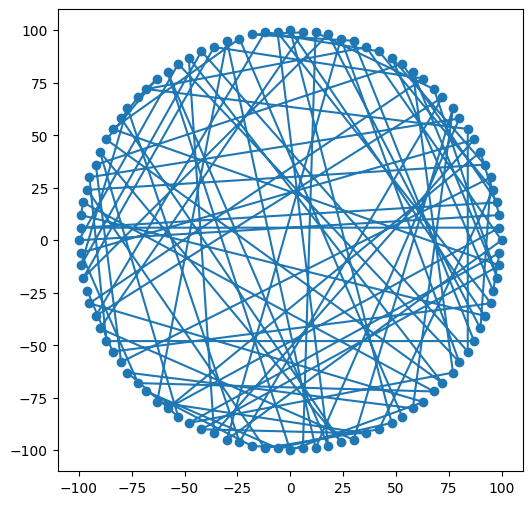

Iterations=  13  Route length=    9868.70  Time=       0.44

Iterations=  400  Route length=    3299.39  Time=       8.03


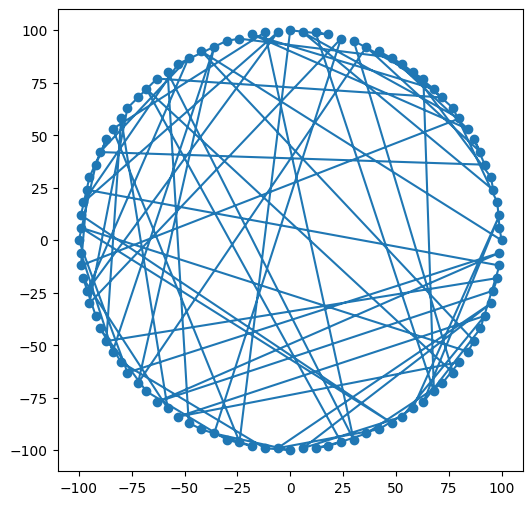

Iterations=  800  Route length=    1996.42  Time=      15.77


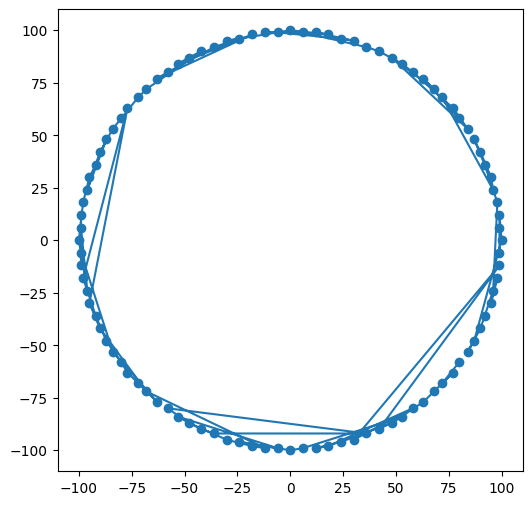

Iterations=  1200  Route length=    1202.19  Time=      23.51


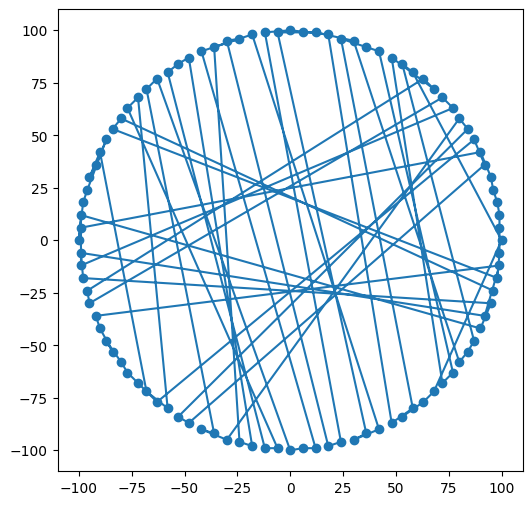

Iterations=  1600  Route length=     930.88  Time=      31.21


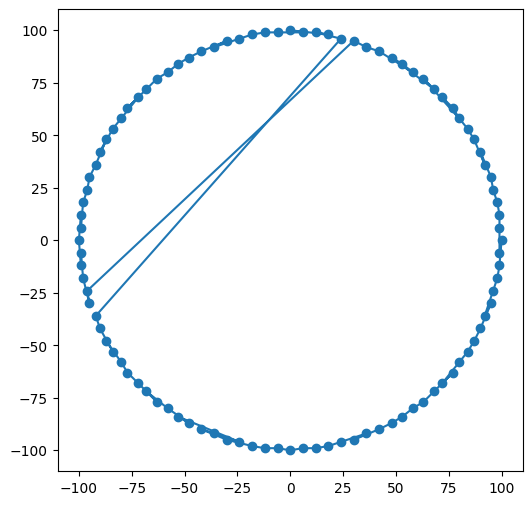

Iterations=  2000  Route length=     777.19  Time=      39.05

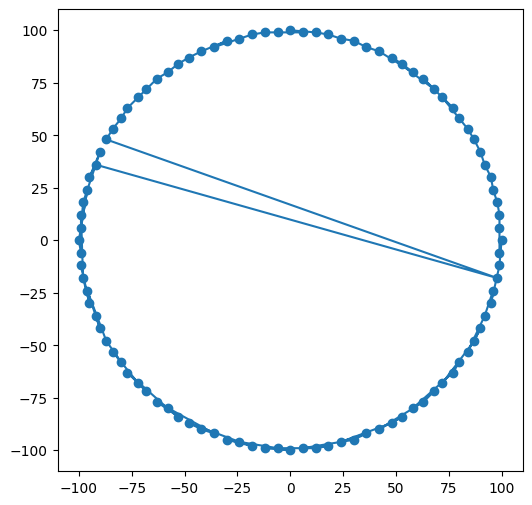


Final route length:     777.19
  Time =  39.14  seconds


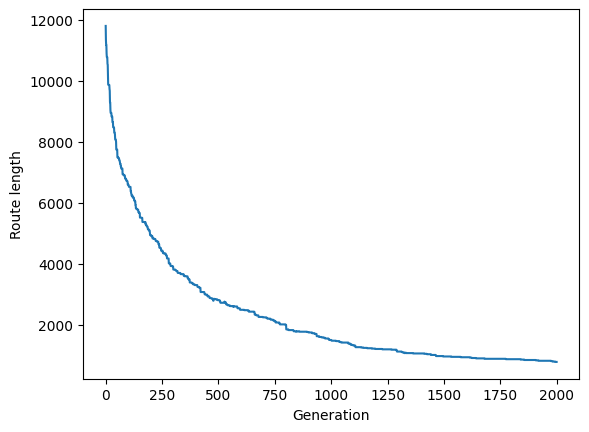

in this run we can check this function for nCities =200
Initial route length:   47240.41




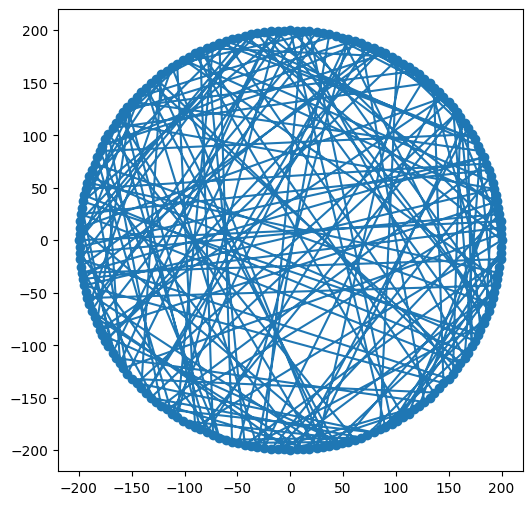

Iterations=  400  Route length=   18688.49  Time=      14.74


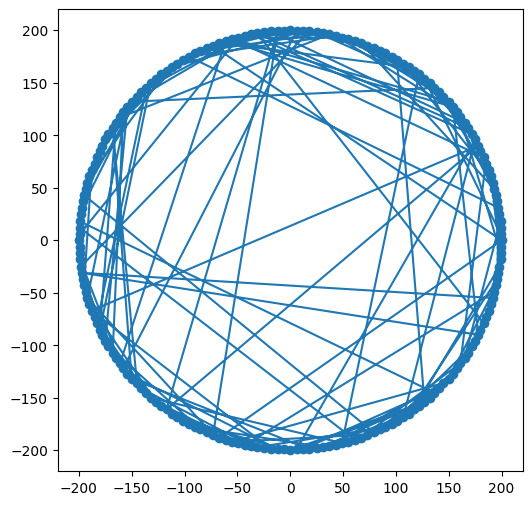

Iterations=  800  Route length=   13238.77  Time=      28.85


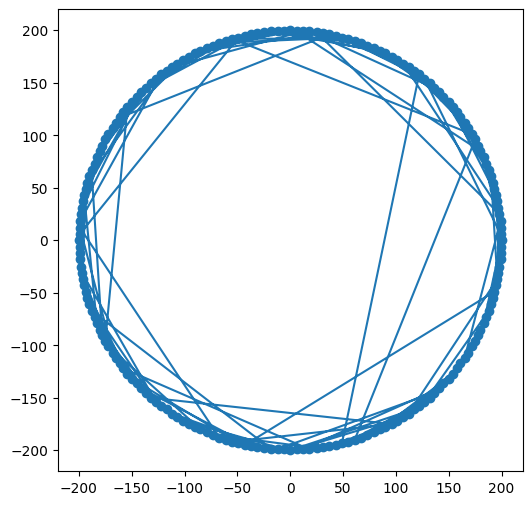

Iterations=  1200  Route length=    9841.39  Time=      42.44


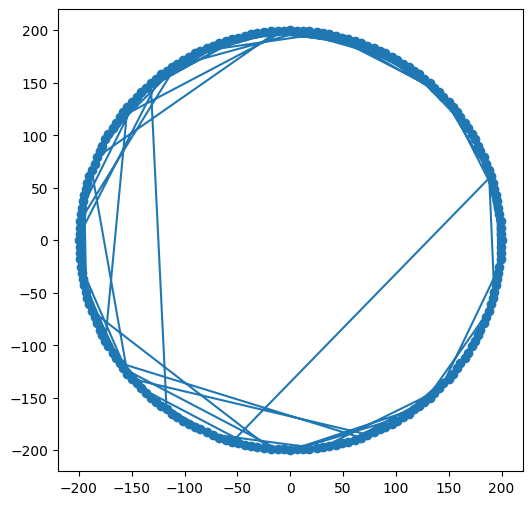

Iterations=  1600  Route length=    7955.69  Time=      56.02


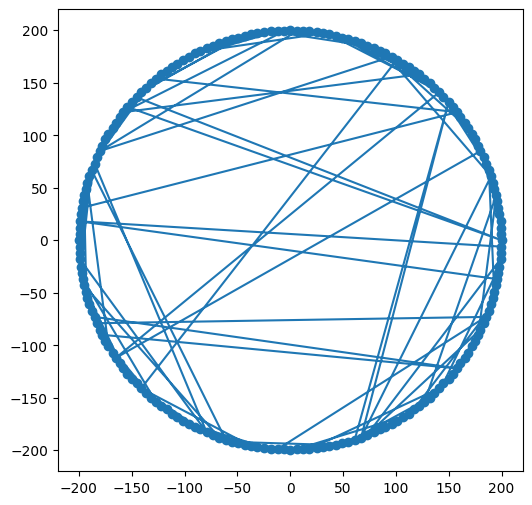

Iterations=  2000  Route length=    6677.34  Time=      70.47

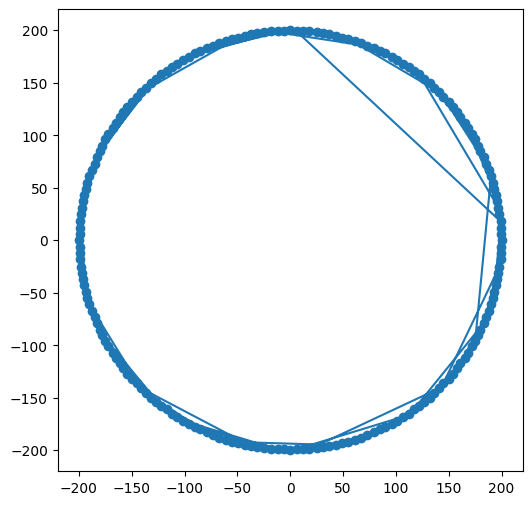


Final route length:    6677.34
  Time =  70.55  seconds


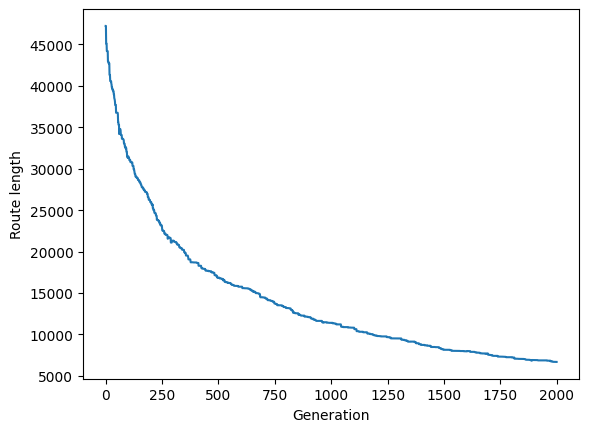

In [22]:
for i in [100,200]:
    print("in this run we can check this function for nCities ={}".format(i))
    nCities=i

    cityList = []

    #cities are regularly positioned on a circumference
    for i in range(0,nCities):
        alpha = i*2*math.pi/nCities
        cityList.append(City(x=int(math.cos(alpha) * nCities), y=int(math.sin(alpha) * nCities)))
    
    bestr = geneticAlgorithm(population=cityList, popSize=50, eliteSize=10, mutationRate=0.0002, generations=2000)
    # # bestr =geneticAlgorithm(population=cityList, popSize=200, eliteSize=20, mutationRate=0.003, generations=3000, n_still=10)

    # #bestr =geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.001, generations=1000, n_still=5)

    # #bestr =geneticAlgorithm(population=cityList, popSize=10, eliteSize=0, mutationRate=0.00, generations=1000, n_still=1000)
